# Imbalanced Classification Using Python

Imbalanced data is where the total number of the positive class (what you want to predict) appears much less frequently than the negative class in the training data. This is a very common issue when creating a classifier to detect people at risk of cancer or credit card fraud detection. The difficulty with these sets of data is that when a model is trained on them it is likely to be very bad at identifying the minority class. This notebook will go over some of the techniques used to combat imbalanced data

## The Data

The data used in this notebook is a sample of US income data. Found [here](http://archive.ics.uci.edu/ml/machine-learning-databases/census-income-mld/) .

The data has an imbalance of around 94%/6%. With the 6% earning higher than $50k a year

This notebook will go over creating a classifier to help predict the people earning over 50k with the limited available data

# Data Exploration

In [473]:
#import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import prince
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
%matplotlib inline

In [474]:
#import training data
df_train = pd.read_csv('./data/train.csv')
df_test  = pd.read_csv('./data/test.csv')

In [475]:
def summary(df):
    """
    Prints summary of data
    
    Arguments: df - pd.DataFrame
    
    Returns: None
    
    """
    
    print("number of rows: %s" % len(df.index))
    print("number of columns: %s" % len(df.columns.values))
    print("List of columns %s" % df.dtypes)
    display(df.head())
    
    return None
summary(df_train)
summary(df_test)

number of rows: 199523
number of columns: 41
List of columns age                                  int64
class_of_worker                     object
industry_code                        int64
occupation_code                      int64
education                           object
wage_per_hour                        int64
enrolled_in_edu_inst_lastwk         object
marital_status                      object
major_industry_code                 object
major_occupation_code               object
race                                object
hispanic_origin                     object
sex                                 object
member_of_labor_union               object
reason_for_unemployment             object
full_parttime_employment_stat       object
capital_gains                        int64
capital_losses                       int64
dividend_from_Stocks                 int64
tax_filer_status                    object
region_of_previous_residence        object
state_of_previous_residence         

,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,enrolled_in_edu_inst_lastwk,marital_status,major_industry_code,major_occupation_code,...,country_father,country_mother,country_self,citizenship,business_or_self_employed,fill_questionnaire_veteran_admin,veterans_benefits,weeks_worked_in_year,year,income_level
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,-50000
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,-50000
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,-50000
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,-50000
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,-50000


number of rows: 99762
number of columns: 41
List of columns age                                  int64
class_of_worker                     object
industry_code                        int64
occupation_code                      int64
education                           object
wage_per_hour                        int64
enrolled_in_edu_inst_lastwk         object
marital_status                      object
major_industry_code                 object
major_occupation_code               object
race                                object
hispanic_origin                     object
sex                                 object
member_of_labor_union               object
reason_for_unemployment             object
full_parttime_employment_stat       object
capital_gains                        int64
capital_losses                       int64
dividend_from_Stocks                 int64
tax_filer_status                    object
region_of_previous_residence        object
state_of_previous_residence         o

,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,enrolled_in_edu_inst_lastwk,marital_status,major_industry_code,major_occupation_code,...,country_father,country_mother,country_self,citizenship,business_or_self_employed,fill_questionnaire_veteran_admin,veterans_benefits,weeks_worked_in_year,year,income_level
0,38,Private,6,36,1st 2nd 3rd or 4th grade,0,Not in universe,Married-civilian spouse present,Manufacturing-durable goods,Machine operators assmblrs & inspctrs,...,Mexico,Mexico,Mexico,Foreign born- Not a citizen of U S,0,Not in universe,2,12,95,-50000
1,44,Self-employed-not incorporated,37,12,Associates degree-occup /vocational,0,Not in universe,Married-civilian spouse present,Business and repair services,Professional specialty,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,26,95,-50000
2,2,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,95,-50000
3,35,Private,29,3,High school graduate,0,Not in universe,Divorced,Transportation,Executive admin and managerial,...,United-States,United-States,United-States,Native- Born in the United States,2,Not in universe,2,52,94,-50000
4,49,Private,4,34,High school graduate,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,50,95,-50000


As we can see from the above the data has a large amount of columns (41) and will most likely benefit from reduction in its size

In [476]:
def list_unique_values_for_columns(df):
    """
    Lists the unique values for all categorical columns
    
    Arguments: df - pd.DataFrame
    
    Returns: None
    
    """
    
    #Assign df to x
    x = df.copy()
    
    for col in x.columns.values:
        if x[col].dtypes == 'object':
            print("column: %s" % col)
            print("list of unique values: %s" % x[col].unique())
    
    return None

#list_unique_values_for_columns(df_train)
#list_unique_values_for_columns(df_test)
#The above have been commented out as took up too much space

If you look closely between the training and test data you will see that some columns in the test set have a space at the start. i.e ' Not in Universe'. This will cause issues when we group the data later so will need to be stripped

# Data Cleaning 

I group the training and testing data together before I clean it. I will then split it back into training and testing data later. If I cleaned them both seperately it could result in different groups being formed in each dataframe which would cause issues when creating the classifier.

In [528]:
#combine both train and test to group low frequency columns 
#this avoids categories that may not have been grouped in train being grouped in test(see below)
group = pd.concat([df_train,df_test],axis=0) 
group.reset_index(inplace=True)
del group['index']

In [529]:
def clean_string_values(df):
    """
    Strips all whitespace, converts to lowercase and replaces spaces
    
    Arguments: df - pd.DataFrame
    
    Returns: x - pd.DataFrame
    
    """
    
    #Assign df to x 
    x = df.copy() 
    
    for col in x.columns.values:
        if x[col].dtypes == 'object':
            x[col] = x[col].str.strip()
            x[col] = x[col].str.lower()
            
    return x 

def convert_income_level(df):
    """
    Converts income_level_column to 0/1
    
    Arguments: df - pd.DataFrame
    
    Returns: x - pd.DataFrame
    
    """
    
    #Assign df to x
    x = df.copy()
    x['income_level'] = x['income_level'].astype(str)
    x['income_level'] = np.where(x['income_level'] == '-50000',0,1)
    
    return x

group=clean_string_values(convert_income_level(group))

In [530]:
group['income_level'].unique()

array([0, 1], dtype=int64)

In [531]:
def remove_columns_with_null_values(df,threshold):
    """
    Removes columns with missing values over a certain percent
    
    Arguments: df:pd.DataFrame, threshold:float
    
    Returns: x:pd.DataFrame
    
    """
    
    #Assign df to x
    x = df.copy()

    #select columns with more than threshold
    x = x.dropna(thresh=threshold*len(x), axis=1)
    #replace all other missing values with string
    x = x.replace(np.nan, 'null_value', regex=True)
    
    return x

print("Number of columns before: %s" % len(group.columns.values))
group = remove_columns_with_null_values(group,0.95)
print("Number of columns after: %s" % len(group.columns.values))

Number of columns before: 41
Number of columns after: 37


In [532]:
def group_low_frequency_categories(df,threshold):
    """
    Groups low frequency categories with less 
    than threshold
    
    Arguments: df:pd.DataFrame,threshold:float
    
    Returns: x:pd.DataFrame
    
    """
    
    #Assign df to x
    x = df.copy()
    
    categories = x.select_dtypes(['object']).copy()
    cols = categories.columns.values
    for col in cols:
        counts= categories[col].value_counts()
        length = categories[col].count()
        values = categories[col].unique()
        for value in values:
            if counts[value] < (length * threshold):
                categories[col].replace(value,'Other',inplace=True)
        for col in categories.columns.values:
            x[col] = categories[col]
            
    return x

group = group_low_frequency_categories(group,0.05)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


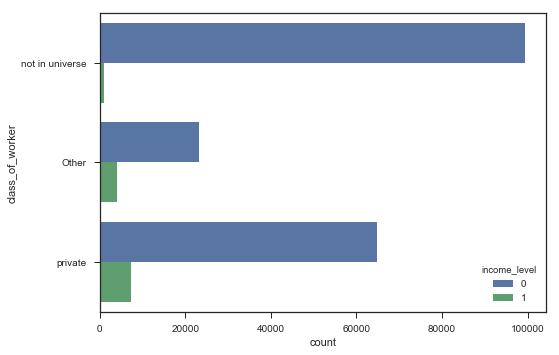

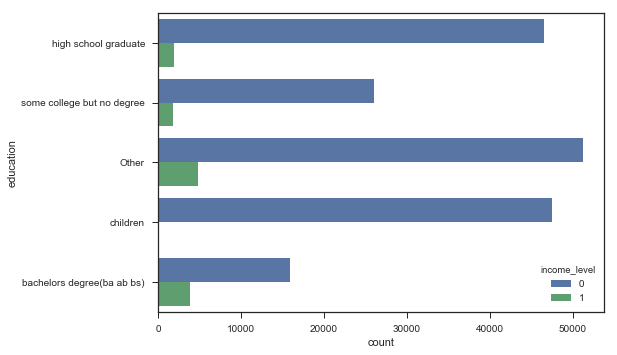

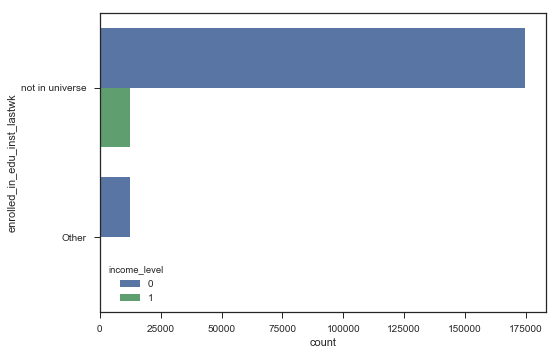

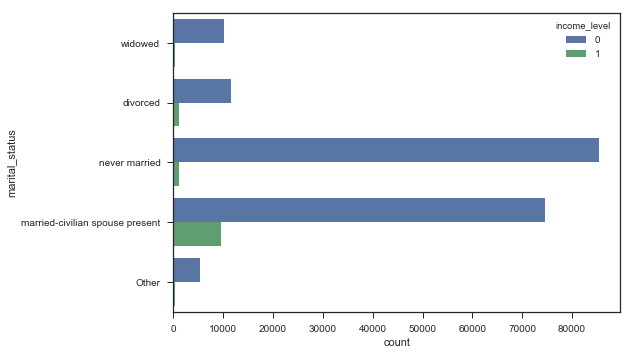

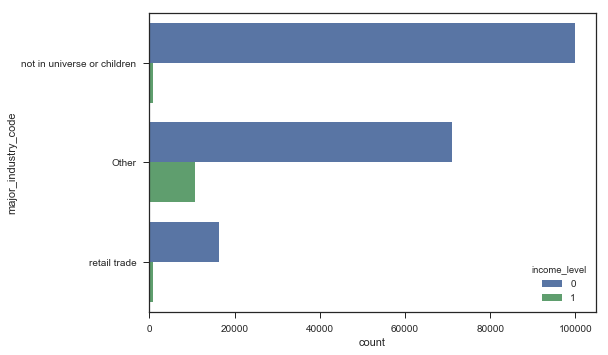

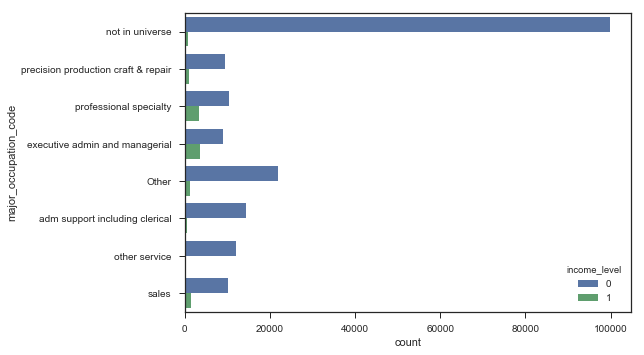

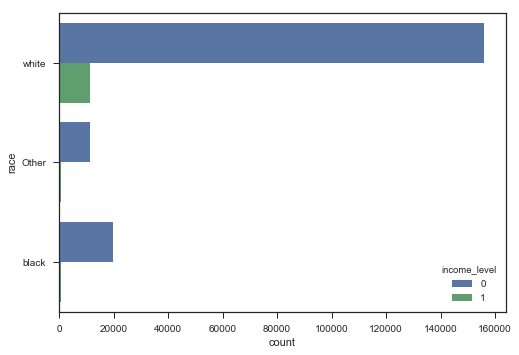

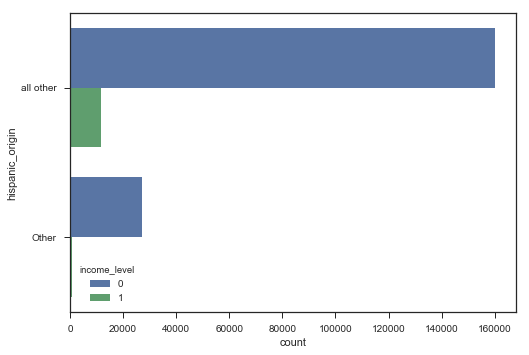

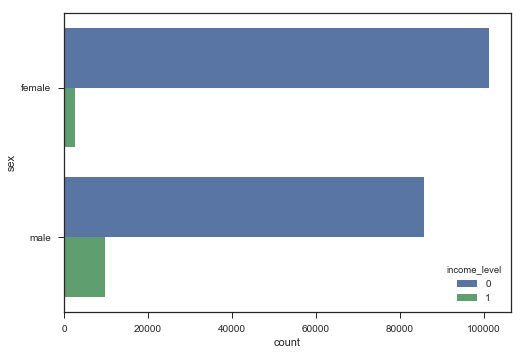

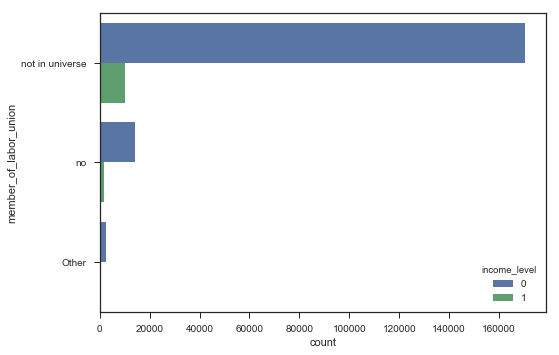

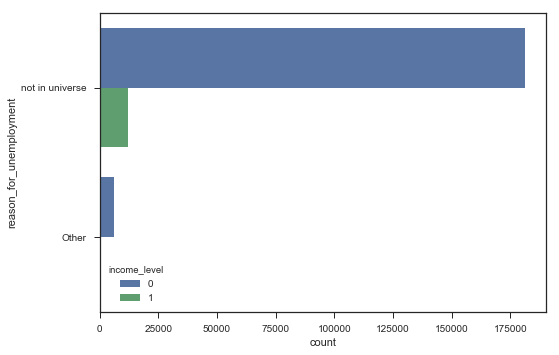

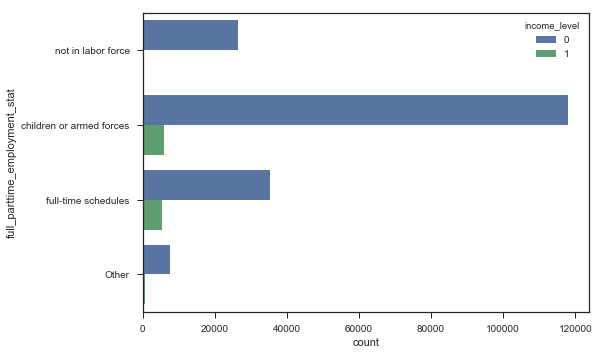

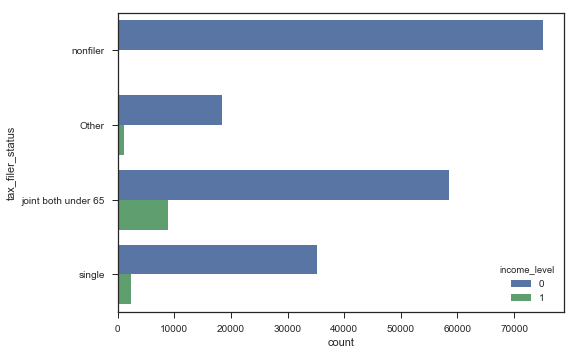

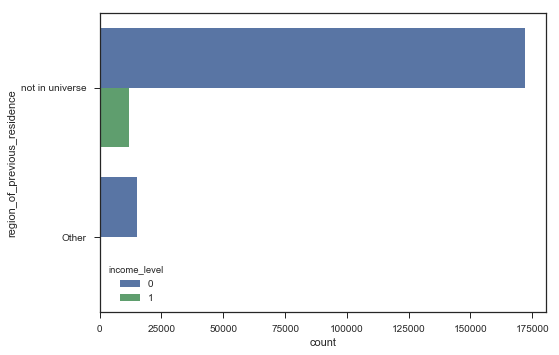

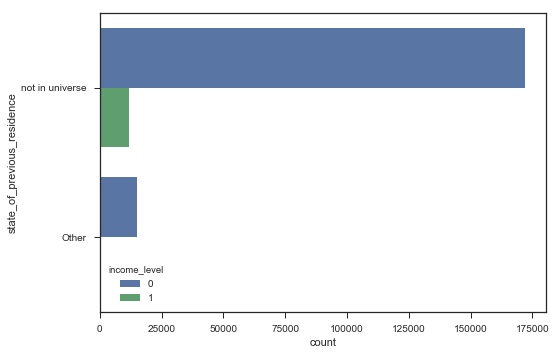

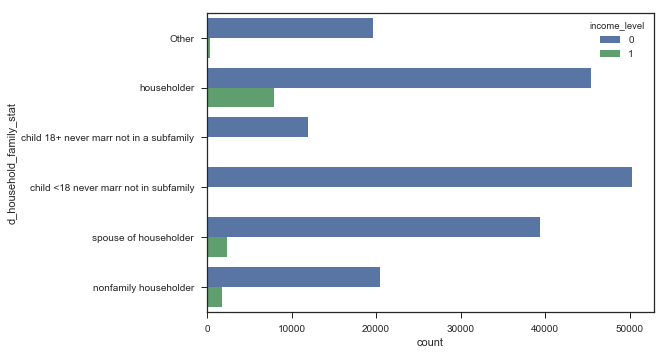

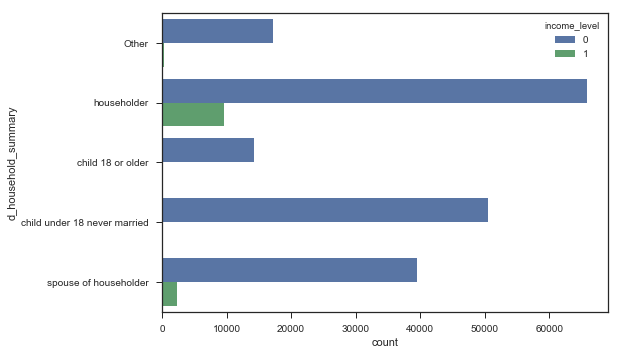

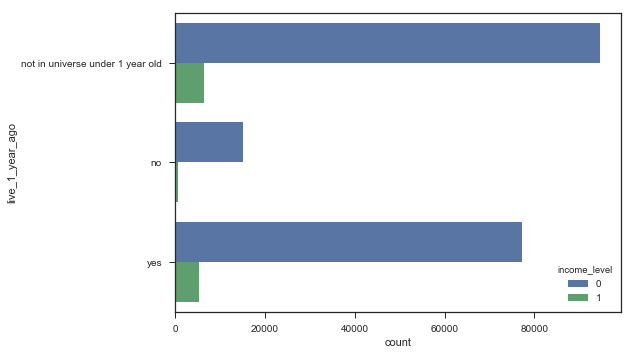

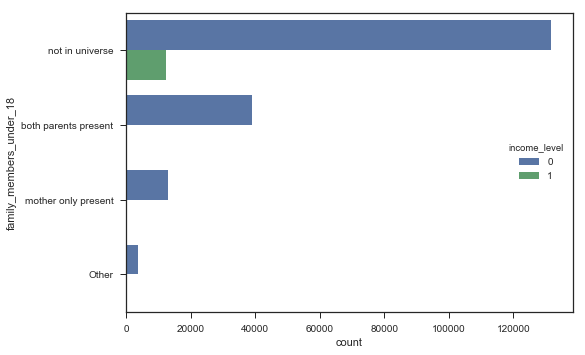

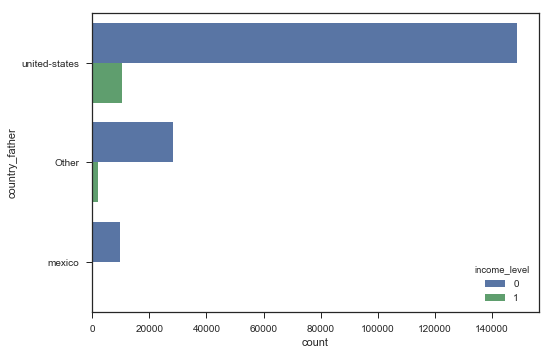

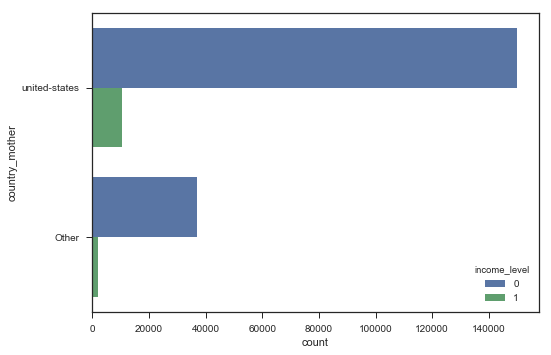

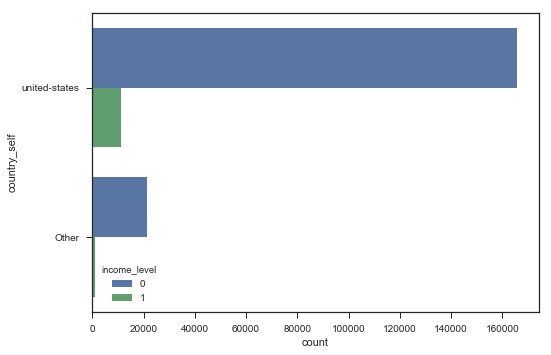

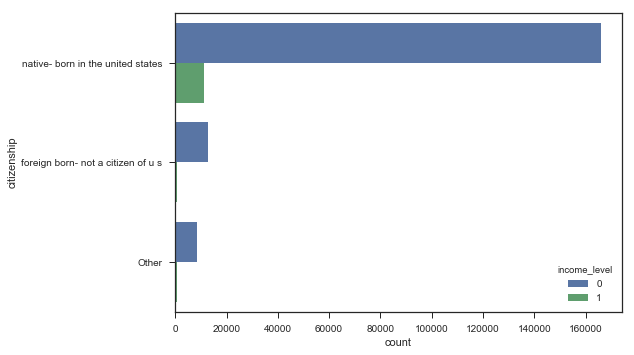

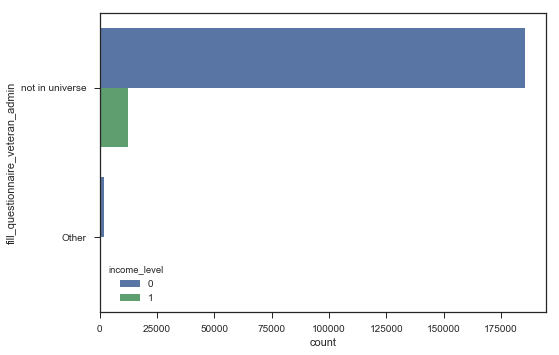

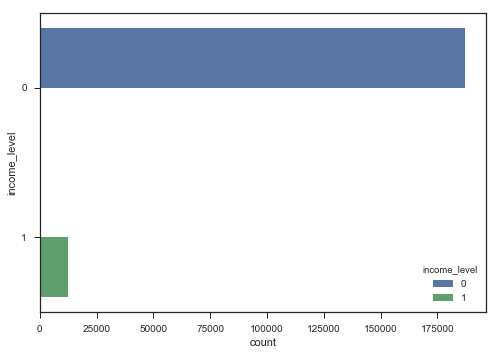

In [533]:
#only visualise training data
train = group[:len(df_train.index)].copy()
categorical = train.select_dtypes(include=['object'])
categorical['income_level'] = train['income_level']
for col in categorical.columns.values:
    plt.figure(col)
    sns.countplot(y=col, hue="income_level", data=categorical)

The above graphs display the counts of all the categorical columns and from them we can see that things like occupation code and education have a fairly sizeable effect.

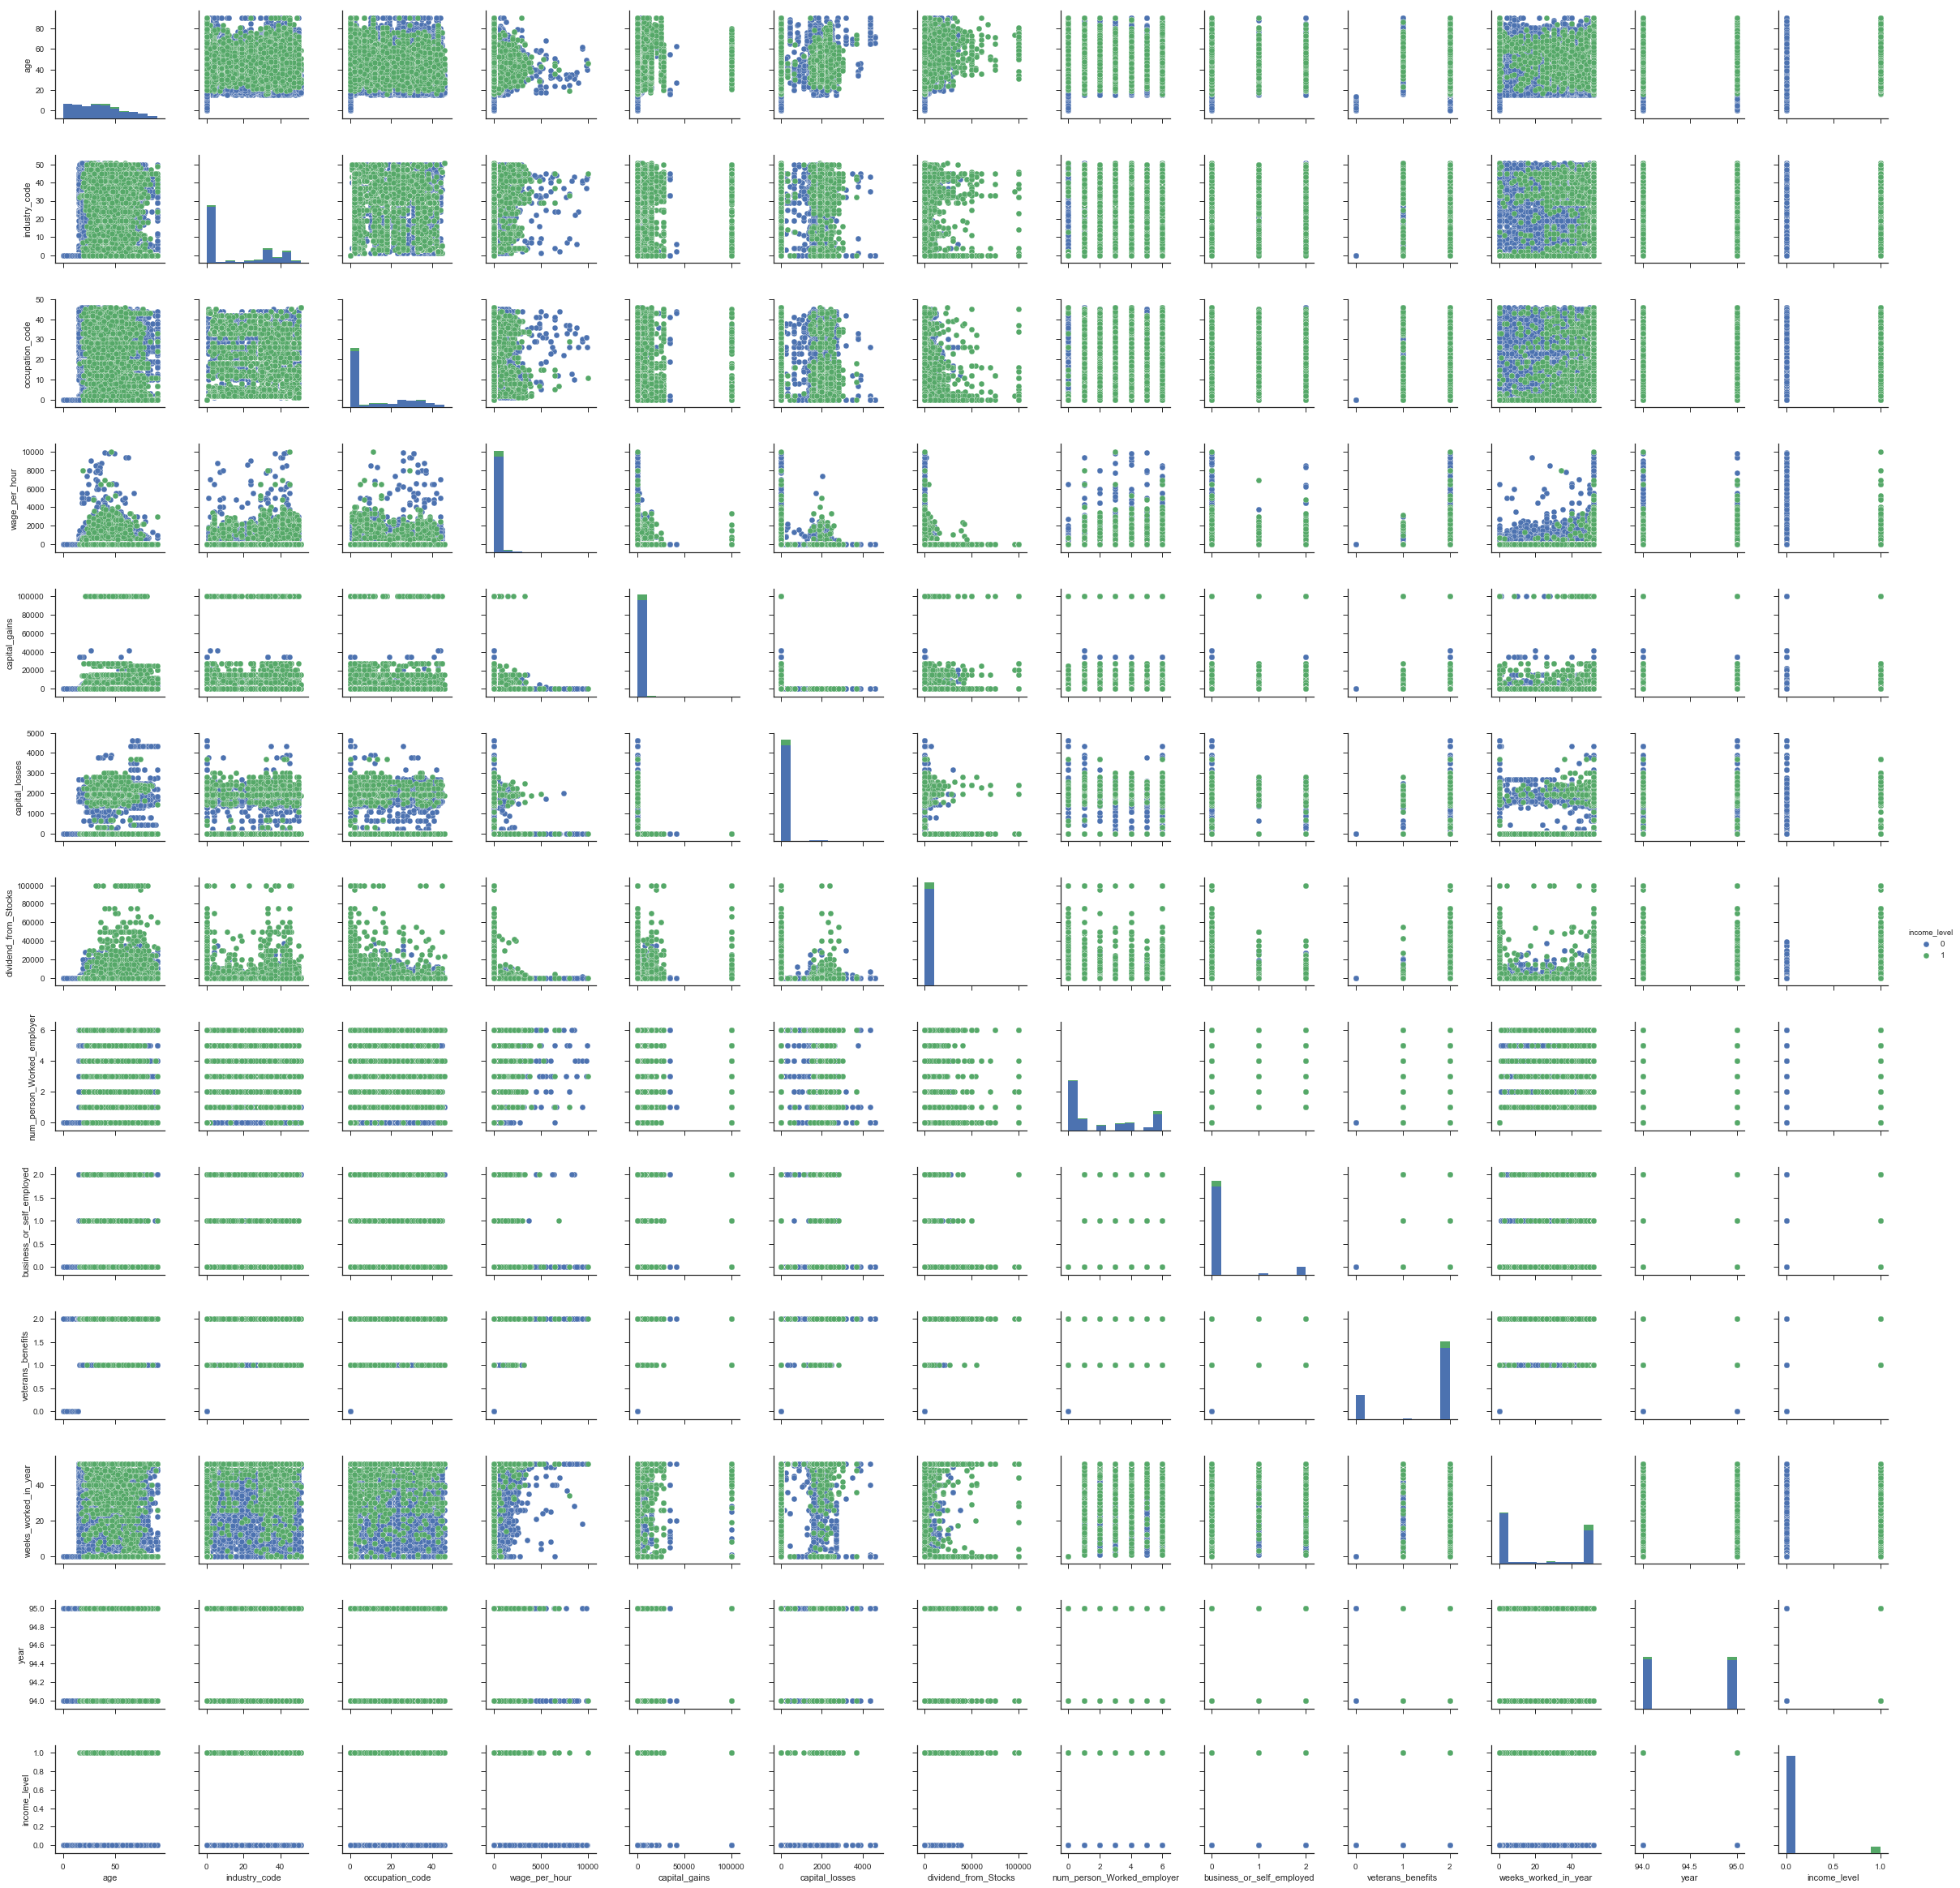

In [483]:
#Create scatter matrix of numeric columns

numeric = train.select_dtypes(exclude=['object'])

sns.set(style="ticks");
sns.pairplot(numeric, hue="income_level")

Scatter matrices are especially useful for spotting trends between variables in your data

# Creating a classifier

In [484]:
continuous_variables = ['age', 
                        'wage_per_hour',
                        'capital_gains',
                        'capital_losses',
                        'dividend_from_Stocks', 
                        'weeks_worked_in_year'
                       ]

def scale_numeric_columns(df):
    """
    Used to scale numeric columns for PCA
    
    Arguments: df - pd.DataFrame
    
    Returns: x - pd.DataFrame
    
    """
    
    #Assign df to x
    x = df.copy()
    
    
        
    scaler = MinMaxScaler()
    numeric = x.select_dtypes(exclude=['object'])
    headers = numeric.columns.values
    scaler.fit(numeric)
    numeric = scaler.transform(numeric)
    numeric = pd.DataFrame(numeric,
                           columns=headers)
    for col in headers:
            x[col] = numeric[col]
    return x

scaled = scale_numeric_columns(group)

In [485]:
def encode_categorical_columns(df):
    """
    Encodes all cateogrical columns as numeric
    
    Arguments: df - pd.DataFrame
    
    Returns: x - pd.DataFrame
    
    """
    
    #Assign df to x
    x = df.copy()
    
    le = LabelEncoder()
    for col in x.columns.values:
        if x[col].dtypes == 'object':
            data = x[col]
            le.fit(data.values.astype(str))
            x[col] = le.transform(data.astype(str))
    
    return x 

encoded = encode_categorical_columns(scaled)

In [486]:
#split back into train and test data 
train_length = len(df_train.index)
#split back into train and test
train = pd.DataFrame()
test  = pd.DataFrame()

if encoded.shape[0] > train_length: # len(df) > 10 would also work
    train = encoded[:train_length]
    test  = encoded[train_length:]
    
print(len(train.index))
print(len(test.index))

199523
99762


In [487]:
#split into training and target
X_train,y_train = train.drop(['income_level'],axis=1),train['income_level']
X_test, y_test  = test.drop(['income_level'],axis=1),test['income_level']

In [488]:
rf = RandomForestClassifier(n_estimators=100,random_state=10,n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=10,
            verbose=0, warm_start=False)

In [489]:
print(rf.score(X_test,y_test))

0.954361380085


As you can the model has scored 95% accuracy which is great but is it really accurate? If you look at the data imbalance of 94/6 the classifier can just guess negative 100% of the time and still have an accuracy of 94% at the least. When dealing with imbalanced datasets the score function is not a good way to evaluate the accuracy of the model

### Feature importance

,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,enrolled_in_edu_inst_lastwk,marital_status,major_industry_code,major_occupation_code,...,family_members_under_18,country_father,country_mother,country_self,citizenship,business_or_self_employed,fill_questionnaire_veteran_admin,veterans_benefits,weeks_worked_in_year,year
0,0.131001,0.015254,0.078153,0.098877,0.048811,0.013782,0.000641,0.01689,0.016315,0.034398,...,0.00073,0.010734,0.009149,0.004747,0.007249,0.017503,0.00198,0.00205,0.045445,0.010361


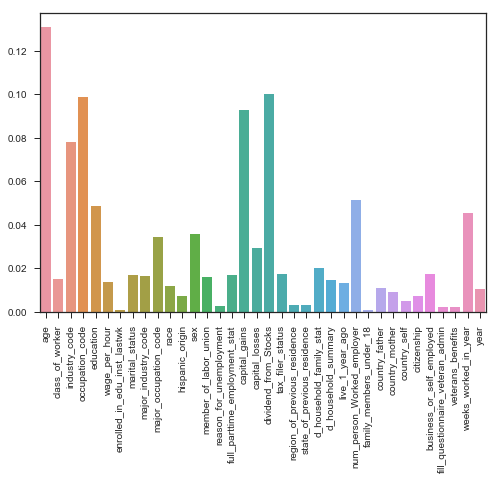

In [490]:
importances=rf.feature_importances_
importance = pd.DataFrame([rf.feature_importances_])
importance.columns = X_train.columns.values
display(importance.head())

g=sns.barplot(data=importance)
g.set_xticklabels(labels =importance.columns.values,rotation=90);

Here we can see that age, occupation code and dividend from stocks are the three most important features

### Scoring an imbalanced classifier

In [491]:
#One way is to remove all the negative classification values from the test dataset
imbalance_test = test[test['income_level'] == 1]
print(len(imbalance_test.index))
X_itest, y_itest  = imbalance_test.drop(['income_level'],axis=1),imbalance_test['income_level']

6186


In [492]:
print(rf.score(X_itest,y_itest))

0.428225024248


So as we can see when we score just on data where people earn above 50k the model is only correctly predicting 42% of them which isn't very useful at all

Another way to score an imbalanced classifier is to use a package called recall_score from sklearn which I'll use from now on as it's less messy. It scores on all the correctly predicted positive values (1) and ignores the negative (0)

In [493]:
print(recall_score(y_test,rf.predict(X_test)))

0.428225024248


There are also other scoring methods that should be considered when creating an imbalanced classifier. Namely precision, recall and f1 score

In [494]:
confusion_matrix(y_test,rf.predict(X_test))

array([[92560,  1016],
       [ 3537,  2649]])

Above is the confusion matrix for our model. A confusion matrix can be thought of as overview of the predictions of the model.

- The top left corner represents True negative values (TN), this is the amount of 0 ( less than 50k ) the model correctly predicted
- The top right corner represents False positive values (FP), this is the amount of times the model incorrectly predicted 1 ( over 50k)
- The bottom left corner represents False Negative values (FN), the amount of times the model guessed 0 and it was actually 1
- The bottom right corner represents True Positive values (TP), the amount of times the model correctly guessed 1

The recall value seen above is the score of 
\begin{equation*}
tp  /  (tp + fn)
\end{equation*}

The recall is intuitively the ability of the classifier to find all the positive samples. [source](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)

The precision is the ratio 
\begin{equation*}
tp / (tp + fp) 
\end{equation*}
where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
[source](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)

In [495]:
print(precision_score(y_test,rf.predict(X_test)))

0.72278308322


The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
\begin{equation*}
F1 = 2 * (precision * recall) / (precision + recall)
\end{equation*}
[source](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)

In [496]:
print(f1_score(y_test,rf.predict(X_test)))

0.537813419957


For the rest of this notebook I will use an sklearn matrix to print all of these at once 

In [497]:
precision_recall_fscore_support(y_test,rf.predict(X_test),average='binary')

(0.72278308321964524, 0.42822502424830261, 0.53781341995736465, None)

# Data Manipulation

In this section I will go over some of the ways to improve the recall score of the model.

### Over sampling the data

One way to deal with imbalanced data is to artificially create more data so that there is an equal split between the positive and negative. To do this I will use a package called SMOTE built in to sci-kit learn

In [498]:
#oversample the data
X_resampled, y_resampled = SMOTE(random_state=0,ratio=1.0).fit_sample(X_train, y_train)
print(Counter(y_resampled))

Counter({0.0: 187141, 1.0: 187141})


In [499]:
rf.fit(X_resampled,y_resampled)
prediction = rf.predict(X_test)

In [500]:
print(rf.score(X_test,y_test))
precision_recall_fscore_support(y_test,rf.predict(X_test),average='binary')

0.94118000842


(0.52344441167797107, 0.57387649531199481, 0.54750154225786551, None)

Now that we have added more data to the data frame we can see that the model has improved by over ten percent to 54%, which is a decent improvement. 

### Under sampling the data

As the name suggests this is the process of removing negative classed data. Usually over sampling is better to use but because this dataset is so big it could be a good candidate for under sampling

In [501]:
rus = RandomUnderSampler(random_state=0)
X_usampled,y_usampled = rus.fit_sample(X_train,y_train)


In [502]:
rf.fit(X_usampled,y_usampled)
prediction = rf.predict(X_test)

In [503]:
print(rf.score(X_test,y_test))
precision_recall_fscore_support(y_test,rf.predict(X_test),average='binary')

0.847547162246


(0.27602641116020454, 0.8988037504041384, 0.42234798131338069, None)

Now the model's recall score has increased to 90% which is a vast improvement. The precision on the other hand has suffered as a  result. Precision and recall are mostly a trade off between the two as to increase the precision would mean predicting positive values with higher certainty which would mean more are missed, lowering the recall. 

## Dimension Reduction

As our dataset is a mix of both discrete and continuous variables it would not be a good idea to use something such as PCA to reduce the dimensions of dataframe. Instead I will look at binning all numeric variables and then using MCA on the categorical data to reduce the dimensionality of the dataframe

In [504]:
numeric = group[continuous_variables]

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


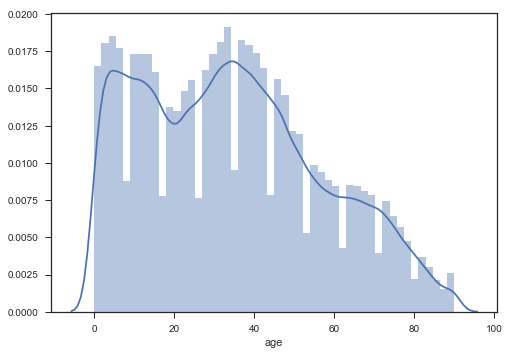

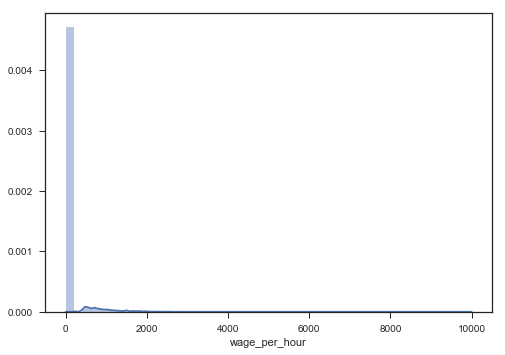

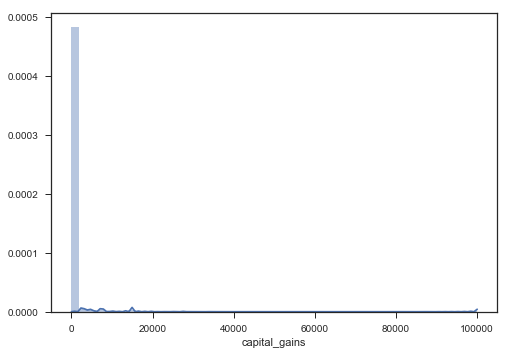

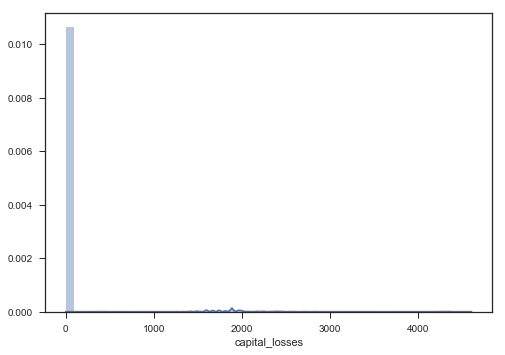

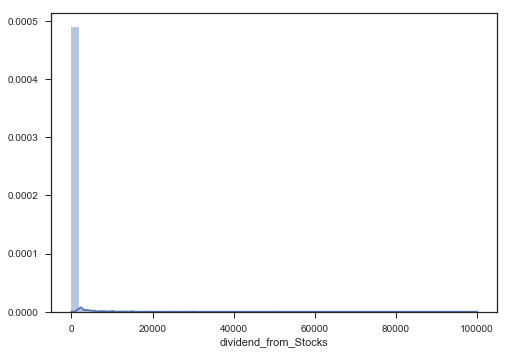

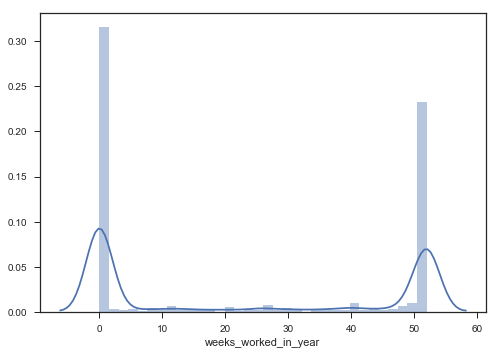

In [526]:
for col in numeric.columns.values:
    plt.figure(col)
    sns.distplot(numeric[col])

From the above it is easy to see that most people don't have capital losses/gains or dividends from stocks so it may be worth binning these variables into (0) or > 0

In [506]:
def bin_variable(df,col,bins):
    """
    Bins a numeric column
    
    Inputs: df-pd.DataFrame,col-string,bins-Int array
    
    Returns: x-pd.DataFrame
    
    """
    
    x=df.copy()
    labels = bins.remove(bins[0])
    binned =pd.cut(x[col],bins,labels=labels)
    x[col] = binned.astype(str)
    return x

binned = group.copy()
#binned = bin_variable(group,'age',[-1,0,20,30,40,50,60,70,90])  
#-500 here to avoid Nan for zero values in dataframe
wage_bin = [i for i in range(-200000,100000,100000)]
#binned = bin_variable(binned,'wage_per_hour',wage_bin)
#binned = bin_variable(binned,'capital_gains',wage_bin)
#binned = bin_variable(binned,'capital_losses',wage_bin)
#binned = bin_variable(binned,'dividend_from_Stocks',wage_bin)

#binned['wage_per_hour'] = np.where(binned['wage_per_hour'] == 0,0,1)
#binned['capital_gains'] = np.where(binned['capital_gains'] == 0,0,1)
#binned['capital_losses'] = np.where(binned['capital_losses'] == 0,0,1)
#binned['dividend_from_Stocks'] = np.where(binned['dividend_from_Stocks'] == 0,0,1)

After binning all the numeric columns in several different ways I found that the model performed worse so I have instead commented out the code above. The random forest classifier implicitly creates its own bins on numeric variables which may also be the reason that the bins above don't perform as well

In [507]:
scaled =scale_numeric_columns(binned)
encoded = encode_categorical_columns(scaled)

In [508]:
#split back into train and test data 
train_length = len(df_train.index)
#split back into train and test
train = pd.DataFrame()
test  = pd.DataFrame()

if encoded.shape[0] > train_length: # len(df) > 10 would also work
    train = encoded[:train_length]
    test  = encoded[train_length:]

#split into training and target
X_train,y_train = train.drop(['income_level'],axis=1),train['income_level']
X_test, y_test  = test.drop(['income_level'],axis=1),test['income_level']

In [509]:
#under sample
rus = RandomUnderSampler(random_state=0)
X_usampled,y_usampled = rus.fit_sample(X_train,y_train)

In [510]:
#get feature importances again from under sampled data
rf.fit(X_usampled,y_usampled)
importances=rf.feature_importances_
importance = pd.DataFrame([rf.feature_importances_])
importance.columns = X_train.columns.values
display(importance.head())

,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,enrolled_in_edu_inst_lastwk,marital_status,major_industry_code,major_occupation_code,...,family_members_under_18,country_father,country_mother,country_self,citizenship,business_or_self_employed,fill_questionnaire_veteran_admin,veterans_benefits,weeks_worked_in_year,year
0,0.110871,0.010777,0.079852,0.119392,0.040202,0.009121,0.001949,0.021276,0.032382,0.031112,...,0.008084,0.007432,0.005958,0.00361,0.005298,0.010739,0.001434,0.00205,0.11326,0.006993


In [511]:
#drop all columns with importance < 0.005
dropped = importance[importance < 0.003].dropna(axis=1)
train_drop = train.drop(dropped.columns.values,axis=1)
test_drop  = test.drop(dropped.columns.values,axis=1)
train_drop.head()
print(len(train_drop.columns.values))

31


I played around with the above threshold quite a bit until I found a sweet spot. 31 columns seems to produce the best results

In [512]:
X_train,y_train = train_drop.drop(['income_level'],axis=1),train_drop['income_level']
X_test, y_test  = test_drop.drop(['income_level'],axis=1),test_drop['income_level']


In [513]:
#over sample
X_resampled, y_resampled = SMOTE(random_state=0,ratio=1.0).fit_sample(X_train, y_train)

In [514]:
#under sample
rus = RandomUnderSampler(random_state=0)
X_usampled,y_usampled = rus.fit_sample(X_train,y_train)

In [515]:
rf = RandomForestClassifier(n_estimators=100,random_state=10,n_jobs=-1)

In [516]:
rf.fit(X_usampled,y_usampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=10,
            verbose=0, warm_start=False)

In [517]:
def score():
    print(rf.score(X_test,y_test))
    print(precision_recall_fscore_support(y_test,rf.predict(X_test),average='binary'))
    return None

score()

0.847978188088
(0.27663914038404142, 0.89896540575493045, 0.42308277541083383, None)


In [518]:
#Fit on over sampled data
rf.fit(X_resampled,y_resampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=10,
            verbose=0, warm_start=False)

In [519]:
score()

0.940809125719
(0.52047209675069217, 0.57743291302942124, 0.5474749022913632, None)


Over sampling here produces a better balance on the f1 score but undersampling produces a far better recall score

### Hyperparameter tuning

In [521]:

clf1 = DecisionTreeClassifier()
clf2 = RandomForestClassifier(random_state=10,n_jobs=-1)
clf3 = GradientBoostingClassifier(random_state=10)

params = {'dt__max_depth': [5, 10], 'rf__n_estimators': [100, 200],'gb__n_estimators':[100,200],
         "rf__max_depth": [3, None,5],
         "rf__max_features": [1,2,3],
         "rf__min_samples_split": [2, 3, 10],
         "rf__min_samples_leaf": [1, 3, 15],
         "gb__max_depth": [3, None,5],
         "gb__max_features": [10,25,30,31],
         "gb__min_samples_split": [ 3, 10,11,12],
         "gb__min_samples_leaf": [1, 3]}


eclf = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2),('gb',clf3)], voting='hard')

random_search = RandomizedSearchCV(eclf, param_distributions=params,n_iter=4)
random_search.fit(X_usampled,y_usampled)
print(random_search.grid_scores_)

[mean: 0.86557, std: 0.00242, params: {'rf__n_estimators': 200, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 15, 'rf__max_features': 2, 'rf__max_depth': 5, 'gb__n_estimators': 100, 'gb__min_samples_split': 10, 'gb__min_samples_leaf': 1, 'gb__max_features': 10, 'gb__max_depth': 3, 'dt__max_depth': 10}, mean: 0.86565, std: 0.00435, params: {'rf__n_estimators': 100, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 3, 'rf__max_features': 3, 'rf__max_depth': 5, 'gb__n_estimators': 200, 'gb__min_samples_split': 11, 'gb__min_samples_leaf': 3, 'gb__max_features': 30, 'gb__max_depth': None, 'dt__max_depth': 10}, mean: 0.86537, std: 0.00331, params: {'rf__n_estimators': 100, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 15, 'rf__max_features': 2, 'rf__max_depth': 3, 'gb__n_estimators': 200, 'gb__min_samples_split': 3, 'gb__min_samples_leaf': 1, 'gb__max_features': 30, 'gb__max_depth': 3, 'dt__max_depth': 10}, mean: 0.87244, std: 0.00411, params: {'rf__n_estimators': 200, 'rf__m

In [522]:
print(random_search.best_params_)

{'rf__n_estimators': 200, 'rf__min_samples_split': 3, 'rf__min_samples_leaf': 3, 'rf__max_features': 3, 'rf__max_depth': None, 'gb__n_estimators': 200, 'gb__min_samples_split': 12, 'gb__min_samples_leaf': 1, 'gb__max_features': 10, 'gb__max_depth': None, 'dt__max_depth': 5}


Here I have used a randomizedsearchcv along with a voting classifier on a decision tree, random forest and gradient boosting classifiers. I have also used a voting classifier to compare the models as they run through the randomized search.

In [523]:
print(random_search.best_score_)

0.8724357938943628


In [524]:
print(random_search.score(X_test,y_test))
precision_recall_fscore_support(y_test,random_search.predict(X_test),average='binary')

0.842304685151


(0.27092532155884047, 0.91254445522146788, 0.4178077122344756, None)

In [525]:
#score on oversampled data
#The random search wouldn't run on the oversampled data so I have just used a gradient boosted classifier here
gb =GradientBoostingClassifier(random_state=10,n_estimators=100,min_samples_split=11,
                               min_samples_leaf=1,max_features=10,max_depth=5)
gb.fit(X_resampled,y_resampled)
print(gb.score(X_test,y_test))
precision_recall_fscore_support(y_test,gb.predict(X_test),average='binary')

0.916110342615


(0.40384107127125363, 0.74102812803103779, 0.52278040713919138, None)

Gradient boosting on the over sampled data produced a better precision whilst also increasing its recall but still underperforms the undersampled data by some way. In the real world picking which model would really depend on what you want to predict. If for example you are predicting cancer rates you would most likely let precision suffer for better recall as false positives are better than false negatives in that situation. Where as if you only needed to pull a small subset of positive values from a data and not all of them you would value precision over recall

In [ ]:
####Code here used to list variables that are taking up the most memory in session 

import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
#sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)